Load mutation profile defintion for Omicron BA.2

In [ ]:
%%bash
wget https://github.com/cbg-ethz/cojac/raw/dev/voc/omicron_ba2_mutations_full.yaml

Load mutation profile defintion for Omicron BA.2

In [ ]:
%%bash
wget https://github.com/cbg-ethz/cojac/raw/dev/voc/omicron_ba5_mutations_full.yaml

In [1]:
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load BA.2 and BA.5 mutations

In [2]:
# load mutations 

with open('omicron_ba2_mutations_full.yaml', 'r') as f:
    ba2_muts = yaml.safe_load(f)
f.close()

with open('omicron_ba5_mutations_full.yaml', 'r') as f:
    ba5_muts = yaml.safe_load(f)
f.close()

In [3]:
all_ba2_pos = set(list(ba2_muts['mut'].keys()) + list(ba2_muts['shared'].keys()))
all_ba5_pos = set(list(ba5_muts['mut'].keys()) + list(ba5_muts['shared'].keys()))

In [4]:
only_ba2 = all_ba2_pos - all_ba5_pos
print("only BA.2:", len(only_ba2))
print(only_ba2)

only_ba5 = all_ba5_pos - all_ba2_pos
print("only BA.5:", len(only_ba5))
print(only_ba5)

only BA.2: 5
{23040, 9866, 26858, 27382, 27259}
only BA.5: 9
{12160, 26529, 21765, 22917, 29734, 23018, 27889, 28882, 28883}


In [5]:
df_muts_def = pd.DataFrame(columns=['position', 'BA.2'])
df_tmp = pd.DataFrame(columns=['position', 'BA.5'])

df_muts_def['position'] = list(ba2_muts['mut'].keys()) + list(ba2_muts['shared'].keys())
df_muts_def['BA.2']=1

df_tmp['position'] = list(ba5_muts['mut'].keys()) + list(ba5_muts['shared'].keys())
df_tmp['BA.5']=1

df_muts_def = pd.merge(df_muts_def, df_tmp, left_on="position", right_on='position', how='outer')
df_muts_def = df_muts_def.fillna(0)

In [6]:
df_muts_def

,position,BA.2,BA.5
0,670,1.0,1.0
1,2790,1.0,1.0
2,4184,1.0,1.0
3,4321,1.0,1.0
4,9424,1.0,1.0
...,...,...,...
69,27889,0.0,1.0
70,12160,0.0,1.0
71,28882,0.0,1.0
72,28883,0.0,1.0


## Positions of mutations that are unique to either BA.2 or BA.5

In [7]:
positions_of_interest = only_ba2.union(only_ba5) 

## Load sample information - location and date

In [8]:
# map sample name to location and date 

fname_sample_names = "../../../../resources/timeline.tsv"

df_mapping = pd.read_csv(fname_sample_names, sep="\t")
df_mapping['my_sample_name'] = df_mapping["sample"] + "/"+df_mapping["batch"]

def f_sample2location(row):
    samplename = row['sample']
    
    location = df_mapping[df_mapping['my_sample_name']==samplename]['location'].values[0]    
    return location

def f_sample2date(row):
    samplename = row['sample']
    date = df_mapping[df_mapping['my_sample_name']==samplename]['date'].values[0]
    
    return date

## Load co-occ mutations

In [9]:
# import co-occ mutations 

df_cocc = pd.read_csv("../../results/all_cooccurring_mutations.csv")
df_cocc = df_cocc[['haplotype_id', 'start', 'end', 'coverage', 'position', 'ref', 'var', 'freq', 'support',
       'sample']]

# map sample name to location and date 
#df_cocc['location'] = df_cocc.apply(f_sample2location, axis=1)
df_cocc['date'] = df_cocc.apply(f_sample2date, axis=1)

In [10]:
df_cocc['date'].unique()

array(['2022-04-07', '2022-04-14', '2022-04-21', '2022-04-28',
       '2022-05-05', '2022-05-12', '2022-04-01', '2022-04-08',
       '2022-04-15', '2022-04-22', '2022-04-29', '2022-05-06',
       '2022-05-13', '2022-04-02', '2022-04-09', '2022-04-23',
       '2022-04-30', '2022-05-07', '2022-05-14', '2022-05-30',
       '2022-05-16', '2022-04-03', '2022-04-17', '2022-04-24',
       '2022-05-01', '2022-05-08', '2022-05-15', '2022-04-04',
       '2022-04-11', '2022-04-18', '2022-04-25', '2022-05-09',
       '2022-04-05', '2022-04-12', '2022-04-19', '2022-04-26',
       '2022-05-10', '2022-04-06', '2022-04-13', '2022-04-20',
       '2022-04-27', '2022-05-04', '2022-05-11', '2022-05-18',
       '2022-06-02', '2022-06-09', '2022-06-03', '2022-06-10',
       '2022-06-17', '2022-06-24', '2022-06-04', '2022-06-11',
       '2022-06-25', '2022-06-05', '2022-06-12', '2022-06-26',
       '2022-06-06', '2022-06-13', '2022-06-20', '2022-06-07',
       '2022-06-14', '2022-06-21', '2022-06-01', '2022-

In [11]:
df_cocc["mutation_id"] = df_cocc["ref"] + df_cocc["position"].astype(str) + df_cocc["var"]

## load coverage

In [12]:
df_coverage = pd.read_csv("../../results/samples.all_coverage.csv")
df_coverage = df_coverage[df_coverage['pos'].isin(list(only_ba5) + list(only_ba2))]
df_coverage['date'] = df_coverage.apply(f_sample2date, axis=1)

## plotting

In [14]:
df_res = df_cocc[df_cocc['position'].isin(df_muts_def['position'])]
df_res = pd.merge(df_res, df_muts_def, left_on = 'position', right_on = 'position', how='left')

def get_mutation_label(row):
    if (row['BA.5'] == 0) & (row['BA.2'] == 1):
           return row['mutation_id'] + " (BA.2)"
    if (row['BA.2'] == 0) & (row['BA.5'] == 1):
           return row['mutation_id'] + " (BA.5)"

df_res['mutation_label'] = df_res.apply(get_mutation_label, axis=1)

In [15]:
df_res = df_res.drop_duplicates()

In [16]:
# list of mutation labels that should be drop since nothing happens there 

drop_mutation = ['A23040T (BA.2)',
                 'A27259T (BA.2)',
                 'G27382T (BA.2)',
                 'G27382A (BA.2)',
                 'T21765C (BA.5)',
                 'T22917A (BA.5)',
                 'T22917C (BA.5)',
                 'T23018A (BA.5)',
                 'G26529A (BA.5)',
                 'G28883A (BA.5)',
                 'G28883T (BA.5)',
                 'G28883C (BA.5)',
                 'G28882A (BA.5)', 
                 'G12160T (BA.5)'
                ]

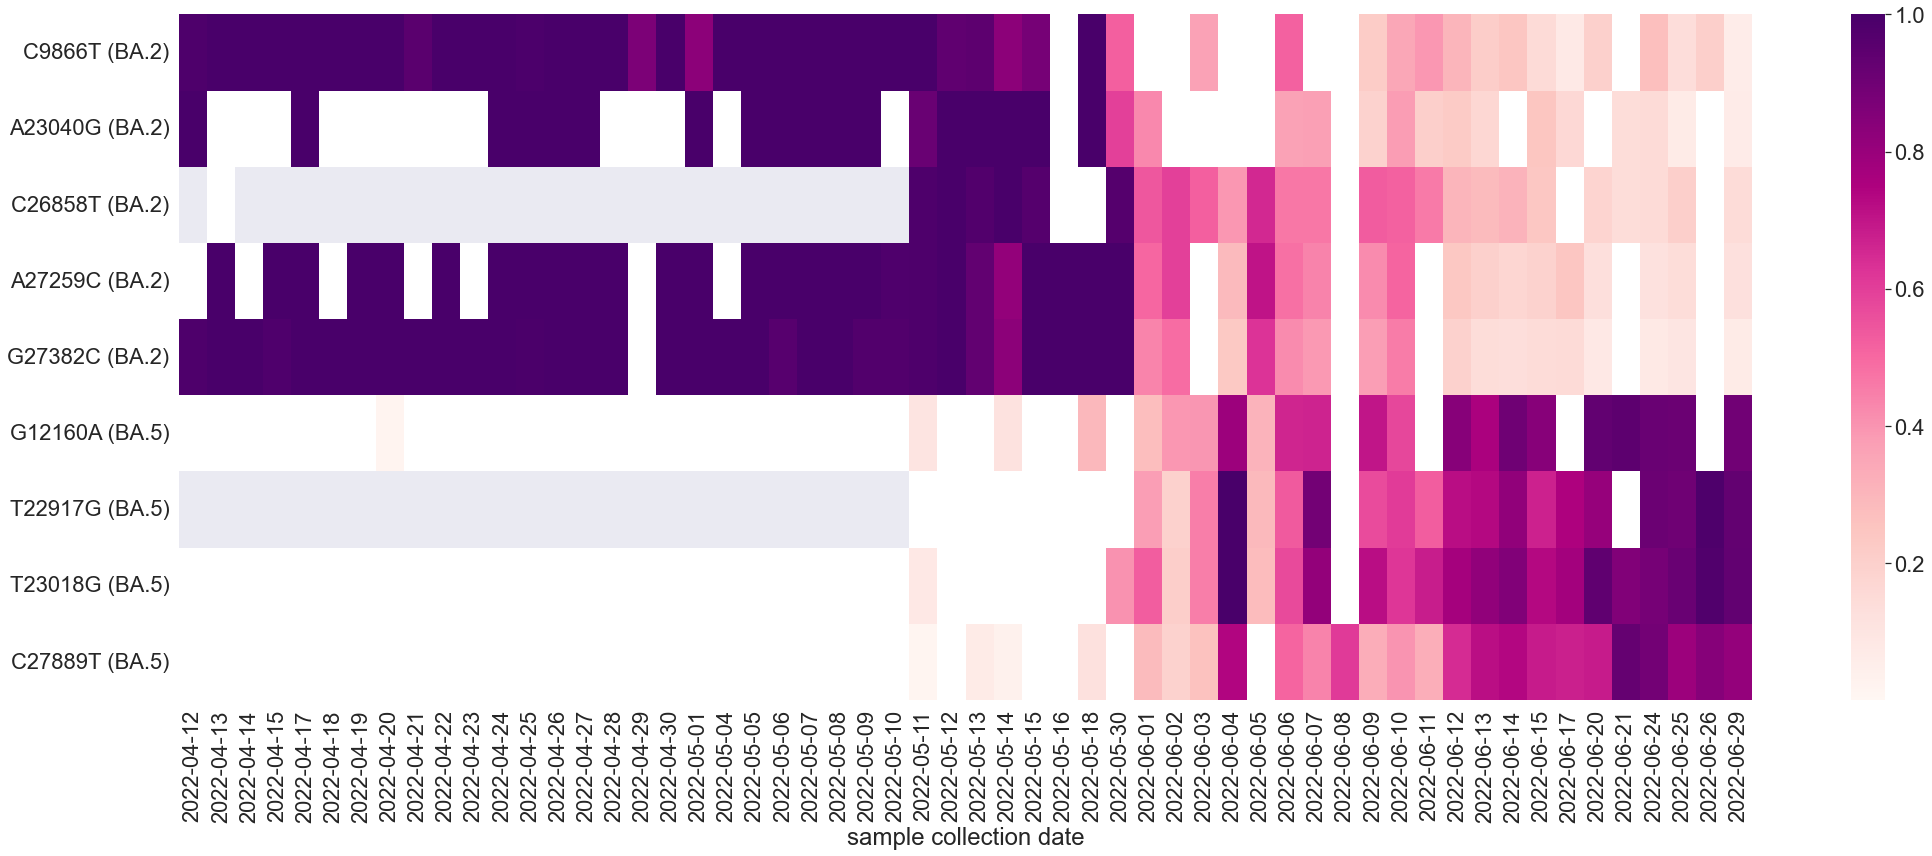

In [17]:
data = df_res[['freq', 'mutation_label', 'date', 'position', "BA.5"]]
data = data[data['position'].isin(list(only_ba5) + list(only_ba2))]
data = data[~data['mutation_label'].isin(drop_mutation)]

drop_early_dates = ['2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04', '2022-04-05', '2022-04-06',
                    '2022-04-07', '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11']
data = data[~data['date'].isin(drop_early_dates)]


orders = data.sort_values(['BA.5', 'position'])['mutation_label'].unique()

data = data.pivot_table(index=['mutation_label', 'position'], 
                        values='freq',
                        columns='date',
                        fill_value=0,
                       ).reset_index()

data = pd.melt(data, 
               id_vars=['mutation_label', 'position'], 
               var_name='date', 
               value_name='freq')

data = pd.merge(data, df_coverage[['pos', 'date', 'coverage']], 
                left_on = ['date', 'position'], 
                right_on= ['date', 'pos'])

data.loc[data['coverage']<1, 'freq'] = np.nan

import numpy as np
data = data.pivot_table(index='mutation_label', 
                        values='freq', 
                        columns='date',
                        #aggfunc=lambda x: np.log10(x),
                       ).reindex(index=orders)

sns.set(font_scale=2.0)

fig = plt.figure(figsize = (30, 12))

ax = fig.add_subplot(111)

import matplotlib as mpl
cmap = mpl.cm.get_cmap("RdPu").copy()
cmap.set_under(color='white')

sns.heatmap(data,
            cmap=cmap,
            vmin=0.000001,
            ax=ax)

ax.set_ylabel('')
ax.set_xlabel('sample collection date')

fig.tight_layout()

fig.savefig('heatmap_freq_ba2_ba5_specific_mutations.pdf')

In [18]:
data

date,2022-04-12,2022-04-13,2022-04-14,2022-04-15,2022-04-17,2022-04-18,2022-04-19,2022-04-20,2022-04-21,2022-04-22,...,2022-06-13,2022-06-14,2022-06-15,2022-06-17,2022-06-20,2022-06-21,2022-06-24,2022-06-25,2022-06-26,2022-06-29
mutation_label,,,,,,,,,,,,,,,,,,,,,
C9866T (BA.2),0.987074,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,0.954065,1.0,...,0.214286,0.245283,0.152174,0.076923,0.200000,0.000000,0.270833,0.138889,0.205882,0.058824
A23040G (BA.2),1.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.0,...,0.171271,0.000000,0.248503,0.160305,0.000000,0.142857,0.149180,0.067172,0.000000,0.063253
C26858T (BA.2),NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.283180,0.308700,0.242161,0.000000,0.181818,0.140927,0.151893,0.205334,0.000000,0.146454
A27259C (BA.2),0.000000,1.0,0.0,1.000000,1.0,0.0,1.0,1.000000,0.000000,1.0,...,0.201584,0.173984,0.190066,0.242997,0.130872,0.000000,0.119028,0.143132,0.000000,0.127151
G27382C (BA.2),0.988015,1.0,1.0,0.983471,1.0,1.0,1.0,1.000000,1.000000,1.0,...,0.143988,0.134959,0.145033,0.150560,0.083893,0.000000,0.080469,0.100865,0.000000,0.066737
G12160A (BA.5),0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.015668,0.000000,0.0,...,0.757166,0.900144,0.841689,0.000000,0.936967,0.947826,0.915842,0.912833,0.000000,0.895637
T22917G (BA.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.733813,0.816964,0.668845,0.749621,0.806250,0.000000,0.913649,0.899609,0.986325,0.930435
T23018G (BA.5),0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.817242,0.857143,0.730594,0.775299,0.940625,0.857143,0.884607,0.915736,0.980342,0.935330
C27889T (BA.5),0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.718710,0.737401,0.686030,0.672941,0.685279,0.928571,0.893048,0.790017,0.845930,0.811148
